# Sonar Mines Vs Rocks Dataset Classification

This exercise classifies if the object being studied is either Rock (R) or a Metal (M) from the 60 sonar readings.

### 1. Prepare Problem
    ## a) Load libraries
    ## b) Load dataset
### 2. Analyze Data
    ## a) Descriptive statistics
    ## b) Data visualizations
### 3. Prepare Data
    ## a) Data Cleaning
    ## b) Feature Selection
    ## c) Data Transforms
### 4. Evaluate Algorithms
    ## a) Split-out validation dataset
    ## b) Test options and evaluation metric
    ## c) Spot Check Algorithms
    ## d) Compare Algorithms
### 5. Improve Accuracy
    ## a) Algorithm Tuning
    ## b) Ensembles
### 6. Finalize Model
    ## a) Predictions on validation dataset
    ## b) Create standalone model on entire training dataset
    ## c) Save model for later use

### 1. Prepare Problem

    ## a) Load libraries

In [1]:
import numpy
from matplotlib import pyplot

from pandas import read_csv
from pandas import set_option
from pandas.plotting import scatter_matrix

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

    ## b) Load dataset

In [2]:
url = 'sonar.all-data.csv'
dataset = read_csv(url, header=None)

### 2. Analyze Data

    ## a) Descriptive statistics

In [3]:
# Observations:
#  - By definition sonar values are lying between 0 and 1
#  - Response variable i.e. feature 60 is object type having values 'M', 'R'

print(dataset.shape)
print(dataset.dtypes)

set_option('display.width', 100)
set_option('display.max_rows', 500)

print(dataset.head(20))

# Observations:
#  - data has same range, but has different mean values
#  - so, we may benefit from standardizing data

set_option('precision', 3)
print(dataset.describe())

# Let us check how the response variable is distributed
# Note that it is reasonably balanced between 'M' and 'R'
print(dataset.groupby(60).size())

(208, 61)
0     float64
1     float64
2     float64
3     float64
4     float64
5     float64
6     float64
7     float64
8     float64
9     float64
10    float64
11    float64
12    float64
13    float64
14    float64
15    float64
16    float64
17    float64
18    float64
19    float64
20    float64
21    float64
22    float64
23    float64
24    float64
25    float64
26    float64
27    float64
28    float64
29    float64
       ...   
31    float64
32    float64
33    float64
34    float64
35    float64
36    float64
37    float64
38    float64
39    float64
40    float64
41    float64
42    float64
43    float64
44    float64
45    float64
46    float64
47    float64
48    float64
49    float64
50    float64
51    float64
52    float64
53    float64
54    float64
55    float64
56    float64
57    float64
58    float64
59    float64
60     object
Length: 61, dtype: object
        0       1       2       3       4       5       6       7       8       9  ...      51  \
0   0.0200  

    ## b) Data visualizations - Unimodal

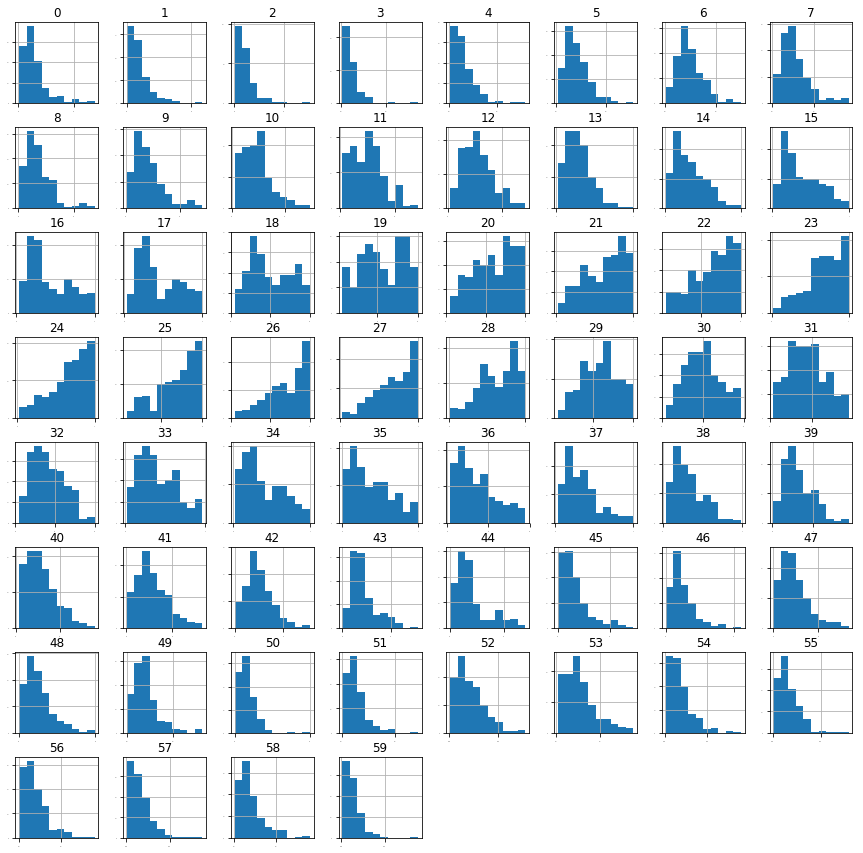

In [4]:
# Histograms
# Obervations:
#  - We see few Guassian and few exponential distributions

dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(15,15))
pyplot.show()

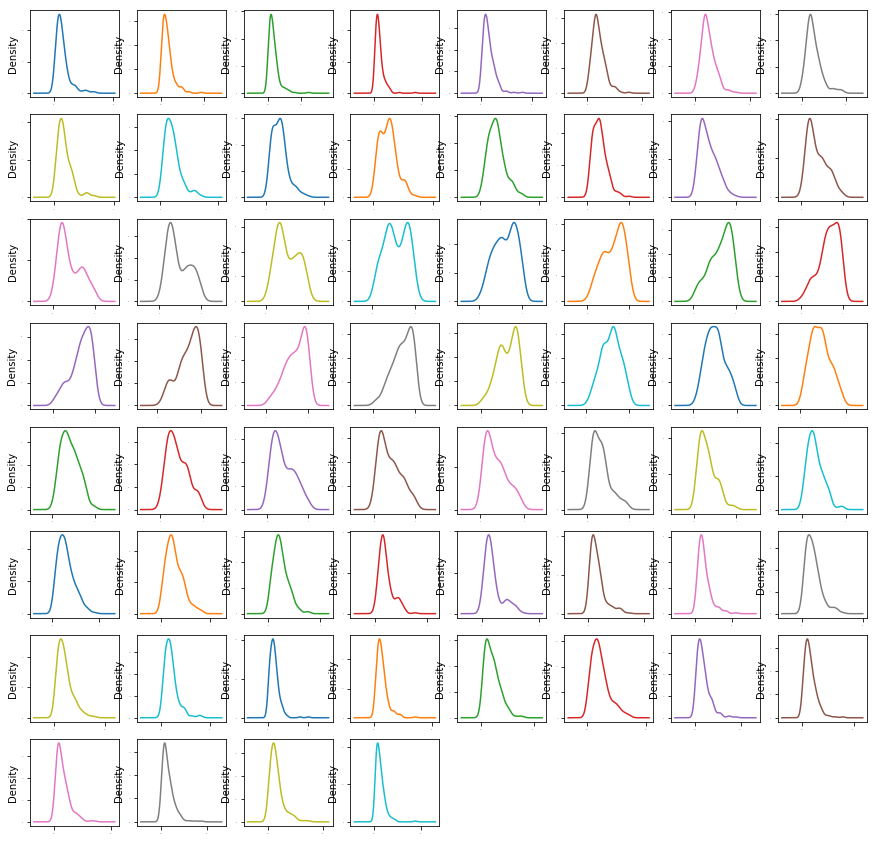

In [5]:
# Density Plots
# Observations:
# - Many distributions are skewed
# - A power transform like a Box-Cox transform that can correct for the skew in distributions might be useful

dataset.plot(kind='density', subplots=True, layout=(8,8), sharex=False, legend=False, fontsize=1, figsize=(15, 15))
pyplot.show()

In [6]:
# Box and whisker plots
# It is always good to look at box and whisker plots of numeric attributes to get an idea of the spread of values

# dataset.plot(kind='box', subplots=True, layout=(8, 8), sharex=False, sharey=False, fontsize=1, figsize=(15, 15))

    ## b) Data visualizations - Multi-modal

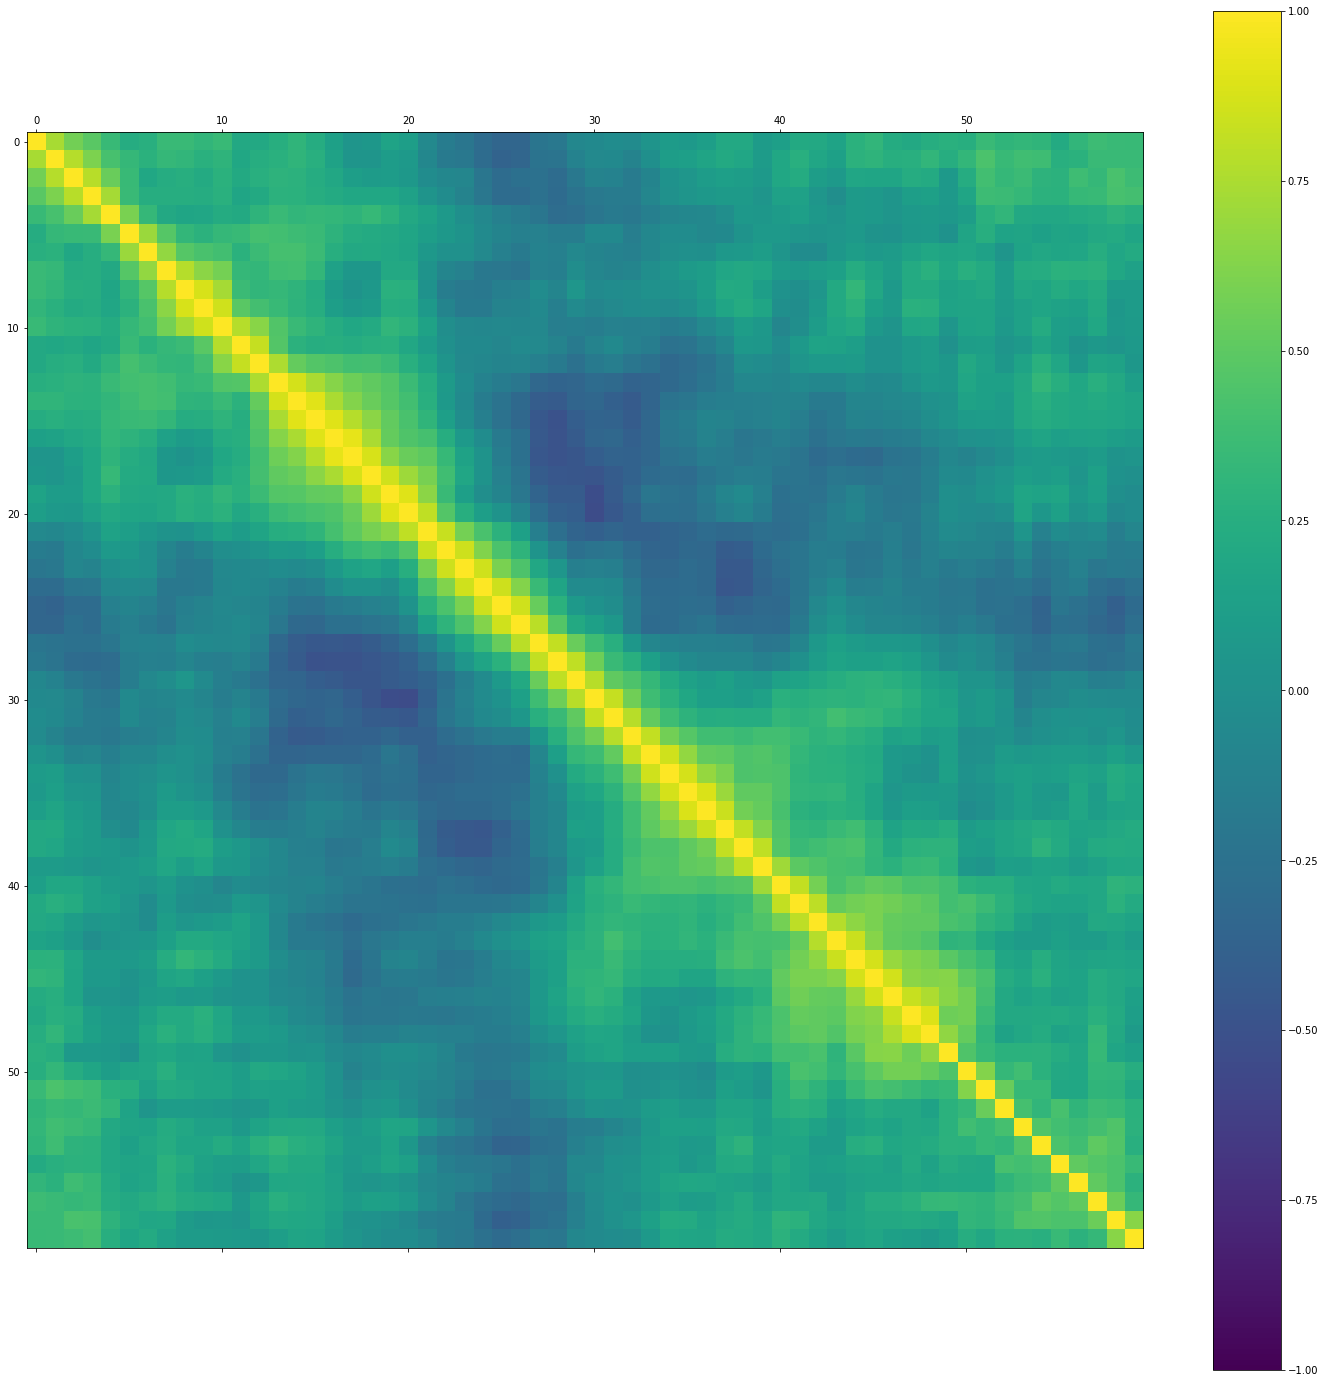

In [7]:
# correlation matrix
# Observations:
#  - The yellow around the diagonal suggests that attributes that are next to each other are generally more correlated
#    with each other. The blue patches also suggest some moderate negative correlation the farther attributes are away 
#    from each other in the ordering. This makes sense if the order of the attributes refers to the angle of sensors 
#    for the sonar chirp
#  Yellow color indicates more correlation
#  Dark color indicates -ve correlation

fig = pyplot.figure(figsize=(25, 25))
ax = fig.add_subplot(111)
cax = ax.matshow(dataset.corr(), vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cax)
pyplot.show()

    ## a) Split-out validation dataset

In [8]:
# Split out validation dataset

array = dataset.values
X = array[:, 0:60].astype(float)
Y = array[:, 60]

validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

### 4. Evaluate Algorithms - Baseline

We don't know what algorithms will do well on this dataset. Gut feel suggests distance based algorithms like 
k-Nearest Neighbors and Support Vector Machines may do well. Let's design our test harness. We will use 10-fold cross validation. The dataset is not too small and this is a good standard test harness configuration. We will evaluate algorithms using the accuracy metric. This is a gross metric that will give a quick idea of how correct a given model is. More
useful on binary classification problems like this one.

In [9]:
num_folds = 10
seed = 7
scoring = 'accuracy'

# Linear Algorithms: 
#    - Logistic Regression (LR)
#    - Linear Discriminant Analysis (LDA)
# Nonlinear Algorithms: 
#    - Classification and Regression Trees (CART)
#    - Support Vector Machines (SVM)
#    - Gaussian Naive Bayes (NB)
#    - k-Nearest Neighbors (KNN)
# Observations:
#  - It may be worth studying LR and KNN

models = []
models.append(('LR', LogisticRegression(solver='lbfgs')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))

results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.769485 (0.100510)
LDA: 0.746324 (0.117854)
KNN: 0.808088 (0.067507)
CART: 0.723162 (0.090116)
NB: 0.648897 (0.141868)
SVM: 0.608824 (0.118656)


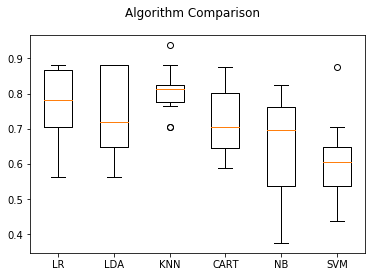

In [10]:
# Compare Algorithms
# Observations:
#  - The results show a tight distribution for KNN which is encouraging, suggesting low variance.
#  - The poor results for SVM are surprising.
#  - It is possible that the varied distribution of the attributes is having an effect on the accuracy
#    of algorithms such as SVM. In the next section we will repeat this spot-check with a standardized
# copy of the training dataset.
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

### Evaluate Algorithms - Baseline

We suspect that the differing distributions of the raw data may be negatively impacting the skill
of some of the algorithms. Let's evaluate the same algorithms with a standardized copy of the
dataset. This is where the data is transformed such that each attribute has a mean value of zero
and a standard deviation of one. We also need to avoid data leakage when we transform the
data. A good way to avoid leakage is to use pipelines that standardize the data and build the
model for each fold in the cross validation test harness. That way we can get a fair estimation
of how each model with standardized data might perform on unseen data.

In [11]:
# Standardize the dataset
# Observations:
# - KNN is improved after standardization
# - SVM improved a lot to become best after standardization

pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression(solver='lbfgs'))])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()),('LDA', LinearDiscriminantAnalysis())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB', GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC())])))

results = []
names = []

for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: 0.740441 (0.094668)
ScaledLDA: 0.746324 (0.117854)
ScaledKNN: 0.825735 (0.054511)
ScaledCART: 0.722426 (0.109843)
ScaledNB: 0.648897 (0.141868)
ScaledSVM: 0.836397 (0.088697)


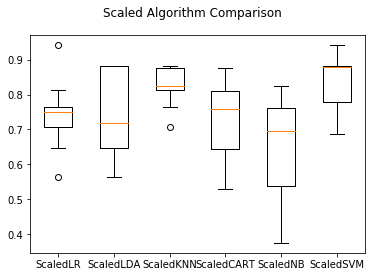

In [12]:
# Compare Algorithms
# Observations:
# - The results suggest digging deeper into the SVM and KNN algorithms. 
# - It is very likely that configuration beyond the default may yield even more accurate models.

fig = pyplot.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

### 5. Improve Accuracy
    ## a) Algorithm Tuning

In [13]:
# Tune scaled KNN
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

neighbors = [1,3,5,7,9,11,13,15,17,19,21]
param_grid = dict(n_neighbors=neighbors)

model = KNeighborsClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(iid=True, estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print()

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.849398 using {'n_neighbors': 1}

0.849398 (0.059881) with: {'n_neighbors': 1}
0.837349 (0.066303) with: {'n_neighbors': 3}
0.837349 (0.037500) with: {'n_neighbors': 5}
0.765060 (0.089510) with: {'n_neighbors': 7}
0.753012 (0.086979) with: {'n_neighbors': 9}
0.734940 (0.104890) with: {'n_neighbors': 11}
0.734940 (0.105836) with: {'n_neighbors': 13}
0.728916 (0.075873) with: {'n_neighbors': 15}
0.710843 (0.078716) with: {'n_neighbors': 17}
0.722892 (0.084555) with: {'n_neighbors': 19}
0.710843 (0.108829) with: {'n_neighbors': 21}


In [14]:
# Tune scaled SVM
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel=kernel_values)

model = SVC(gamma='auto')
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(iid=True, estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print()

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.867470 using {'C': 1.5, 'kernel': 'rbf'}

0.759036 (0.098863) with: {'C': 0.1, 'kernel': 'linear'}
0.530120 (0.118780) with: {'C': 0.1, 'kernel': 'poly'}
0.572289 (0.130339) with: {'C': 0.1, 'kernel': 'rbf'}
0.704819 (0.066360) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.746988 (0.108913) with: {'C': 0.3, 'kernel': 'linear'}
0.644578 (0.132290) with: {'C': 0.3, 'kernel': 'poly'}
0.765060 (0.092312) with: {'C': 0.3, 'kernel': 'rbf'}
0.734940 (0.054631) with: {'C': 0.3, 'kernel': 'sigmoid'}
0.740964 (0.083035) with: {'C': 0.5, 'kernel': 'linear'}
0.680723 (0.098638) with: {'C': 0.5, 'kernel': 'poly'}
0.789157 (0.064316) with: {'C': 0.5, 'kernel': 'rbf'}
0.746988 (0.059265) with: {'C': 0.5, 'kernel': 'sigmoid'}
0.746988 (0.084525) with: {'C': 0.7, 'kernel': 'linear'}
0.740964 (0.127960) with: {'C': 0.7, 'kernel': 'poly'}
0.813253 (0.084886) with: {'C': 0.7, 'kernel': 'rbf'}
0.753012 (0.058513) with: {'C': 0.7, 'kernel': 'sigmoid'}
0.759036 (0.096940) with: {'C': 0.9, 'kernel': 'linear

### 5. Improve Accuracy 
    ## b) Ensembles

In [15]:
#Bagging Methods: 
#    - Random Forests (RF)
#    - Extra Trees (ET)

#Boosting Methods: 
#    - AdaBoost (AB)
#    - Gradient Boosting (GBM)

In [16]:
# ensembles
ensembles = []
ensembles.append(('AB', AdaBoostClassifier(n_estimators=100)))
ensembles.append(('GBM', GradientBoostingClassifier(n_estimators=100)))
ensembles.append(('RF', RandomForestClassifier(n_estimators=100)))
ensembles.append(('ET', ExtraTreesClassifier(n_estimators=100)))

results = []
names = []

for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

AB: 0.813235 (0.057658)
GBM: 0.841912 (0.088694)
RF: 0.848529 (0.095047)
ET: 0.890074 (0.086431)


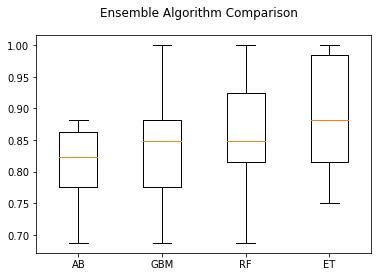

In [17]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

### 6. Finalize Model

In [18]:
# prepare the model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = SVC(C=1.5)
model.fit(rescaledX, Y_train)

# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.8571428571428571
[[23  4]
 [ 2 13]]
              precision    recall  f1-score   support

           M       0.92      0.85      0.88        27
           R       0.76      0.87      0.81        15

   micro avg       0.86      0.86      0.86        42
   macro avg       0.84      0.86      0.85        42
weighted avg       0.86      0.86      0.86        42

